In [239]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [240]:
train = pd.read_csv("MatchesAndRatings.csv")
test = pd.read_csv("testCSV.csv")

In [241]:
train.head()

,Unnamed: 0.1,Unnamed: 0,HomeTeam,AwayTeam,HomeScore,AwayScore,Time,Ref,HomeForm,AwayForm,HomeMissingPlayers,AwayMissingPlayers,Round,GD,HomeAtt,HomeDef,HomeMid,HomeOVR,AwayAtt,AwayDef,AwayMid,AwayOVR,y,Year,Month,Day,Round_Number
0,0,0,Newcastle,Leicester,0,0,2023-05-22 22:00:00,Andre Marriner,10,5,6,6,Premier League Round 37 2022/2023,0,78,79,76,78,79,78,79,79,0,2023,5,22,37
1,1,1,Brighton,Man City,1,1,2023-05-24 22:00:00,Simon Hooper,9,13,6,5,Premier League Round 32 2022/2023,0,76,77,75,76,85,86,86,85,0,2023,5,24,32
2,2,2,Man United,Chelsea,4,1,2023-05-25 22:00:00,Stuart Attwell,9,4,5,8,Premier League Round 32 2022/2023,3,81,80,82,82,83,83,86,84,1,2023,5,25,32
3,3,3,Arsenal,Wolves,5,0,2023-05-28 18:30:00,Andre Marriner,6,7,5,2,Premier League Round 38 2022/2023,5,83,79,80,80,79,77,79,78,1,2023,5,28,38
4,4,4,Aston Villa,Brighton,2,1,2023-05-28 18:30:00,David Coote,7,7,2,0,Premier League Round 38 2022/2023,1,79,80,78,79,76,77,75,76,1,2023,5,28,38


In [242]:
dropped_columns = ['Unnamed: 0.1', 'Unnamed: 0', 'HomeScore', 'AwayScore', 'y', 'Year', 'Day', 'Time', 'GD', 'Round']
y_train = train['y'].copy()
y_test = test['y'].copy()

Xtrain = train.drop(dropped_columns, axis=1)
Xtest = test.drop(dropped_columns, axis=1)

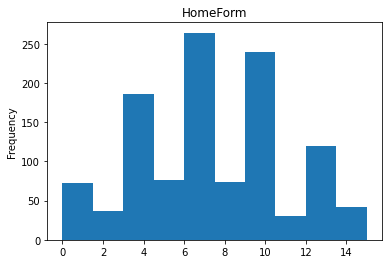

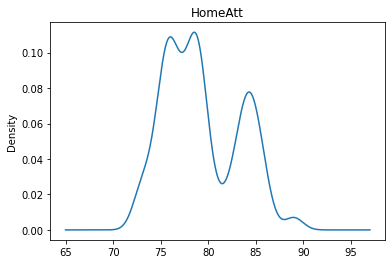

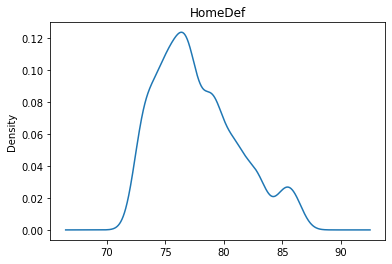

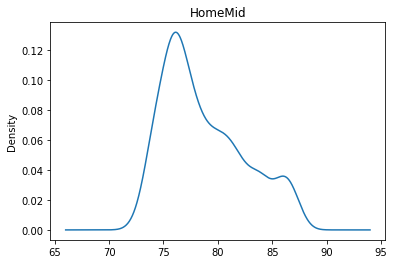

In [243]:
Xtrain['HomeForm'].plot.hist()
plt.title('HomeForm')
plt.show()
Xtrain['HomeAtt'].plot.density()
plt.title('HomeAtt')
plt.show()
Xtrain['HomeDef'].plot.density()
plt.title('HomeDef')
plt.show()
Xtrain['HomeMid'].plot.density()
plt.title('HomeMid')
plt.show()

### Pre-Proccessing: We will encode the HomeTeam, AwayTeam and the Ref

In [244]:

def X_fit_with_dummy(X, feature, na_val):
    '''
    Encode a categorical feature with dummy variables and return the unique values, encoder object, and the new dataset
    Parameters:
        X: Input dataset
        feature: Name of the categorical feature to be encoded
        na_val: Value to replace missing values in the feature
    Returns:
        values: Unique values of the feature
        encoder: Encoder object used for transformation
        new_df: DataFrame with encoded dummy variables
    '''
    X[feature].fillna(na_val, inplace=True)
    values = X[feature].unique()
    encoder = OneHotEncoder(handle_unknown='ignore')
    dummy_var = encoder.fit_transform(X[[feature]]).toarray()
    X.reset_index(drop=True, inplace=True)
    dummy_df = pd.DataFrame(dummy_var, columns=encoder.get_feature_names_out([feature]))
    new_df = pd.concat([X, dummy_df], axis=1)
    #new_df.drop([feature, feature+'_'+na_val],axis=1, inplace=True) ## We don't need it, no NA
    return values, encoder, new_df




def X_with_dummy(X, feature, na_val, encoder, train_values):
    '''
    Encode a categorical feature with dummy variables based on an existing encoder object and return the modified dataset
    Parameters:
        X: Input dataframe
        feature: Name of the categorical feature to be encoded
        na_val: Value to replace missing values in the feature
        encoder: Encoder object for transforming the feature (CustomEncoder)
        train_values: Unique values of the feature in the training data
    Returns:
        X: DataFrame with encoded dummy variables
    '''
    X[feature].fillna(na_val, inplace=True)
    
    # Replace categories not in the known set with 'unknown' in the test data
    X[feature] = X[feature].apply(lambda x: x if x in train_values else 'unknown')
    
    dummy_variables = encoder.transform(X[[feature]]).toarray()
    dummy_df = pd.DataFrame(dummy_variables, columns=encoder.get_feature_names_out([feature]))
    
    X.reset_index(drop=True, inplace=True)
    X = pd.concat([X, dummy_df], axis=1)
    #X.drop([feature, feature+'_'+na_val], axis=1, inplace=True)
    
    return X

In [245]:
### Home Team
team_val, enc, Xtrain = X_fit_with_dummy(Xtrain, 'HomeTeam', 'unknown')
Xtest = X_with_dummy(Xtest, 'HomeTeam', 'unknown', enc, team_val)

### Away Team
team_val, enc, Xtrain = X_fit_with_dummy(Xtrain, 'AwayTeam', 'unknown')
Xtest = X_with_dummy(Xtest, 'AwayTeam', 'unknown', enc, team_val)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [246]:
Xtrain.drop(['HomeTeam', 'AwayTeam', 'Ref'], inplace=True, axis=1)
Xtest.drop(['HomeTeam', 'AwayTeam', 'Ref'], inplace=True, axis=1)

## Now that we only have numeric values:

#### We can now consider further manipulation to the data

lets start by doing log(HomeX/AwayX)

In [247]:
later_removed = ['HomeAtt', 'HomeMid', 'HomeDef', 'HomeOVR',
                 'AwayAtt', 'AwayMid', 'AwayDef', 'AwayOVR']

factors = ['Att', 'Def', 'Mid', 'OVR']

In [248]:
def get_emphasis(df, factors, base):
    for f in factors:
        df['Home'+f+'to'+base] = np.log(df["Home"+f]) - np.log(df['Home'+base])
        df['Away'+f+'to'+base] = np.log(df["Away"+f]) - np.log(df['Away'+base])

In [249]:
get_emphasis(Xtrain, ['Att', 'Def', 'Mid'], 'OVR')
get_emphasis(Xtest, ['Att', 'Def', 'Mid'], 'OVR')

Xtrain.drop(later_removed, inplace=True, axis=1)
Xtest.drop(later_removed, inplace=True, axis=1)

In [251]:
# Get the column types
column_types = Xtrain.dtypes

print(column_types)

HomeForm                     int64
AwayForm                     int64
HomeMissingPlayers           int64
AwayMissingPlayers           int64
Month                        int64
Round_Number                 int64
HomeTeam_Arsenal           float64
HomeTeam_Aston Villa       float64
HomeTeam_Bournemouth       float64
HomeTeam_Brentford         float64
HomeTeam_Brighton          float64
HomeTeam_Burnley           float64
HomeTeam_Cardiff           float64
HomeTeam_Chelsea           float64
HomeTeam_Crystal Palace    float64
HomeTeam_Everton           float64
HomeTeam_Fulham            float64
HomeTeam_Huddersfield      float64
HomeTeam_Leeds             float64
HomeTeam_Leicester         float64
HomeTeam_Liverpool         float64
HomeTeam_Man City          float64
HomeTeam_Man United        float64
HomeTeam_Newcastle         float64
HomeTeam_Norwich           float64
HomeTeam_Nottm Forest      float64
HomeTeam_Southampton       float64
HomeTeam_Tottenham         float64
HomeTeam_Watford    

In [252]:
Xtrain.head()

,HomeForm,AwayForm,HomeMissingPlayers,AwayMissingPlayers,Month,Round_Number,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nottm Forest,HomeTeam_Southampton,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Ham,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Bournemouth,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nottm Forest,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Ham,AwayTeam_Wolves,HomeAtttoOVR,AwayAtttoOVR,HomeDeftoOVR,AwayDeftoOVR,HomeMidtoOVR,AwayMidtoOVR
0,10,5,6,6,5,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012739,-0.012739,-0.025975,0.000000
1,9,13,6,5,5,32,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013072,0.011696,-0.013245,0.011696
2,9,4,5,8,5,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012270,-0.011976,-0.024693,-0.011976,0.000000,0.023530
3,6,7,5,2,5,38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.036814,0.012739,-0.012579,-0.012903,0.000000,0.012739
4,7,7,2,0,5,38,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012579,0.013072,-0.012739,-0.013245


In [253]:
def fit_normalize_data(train, scaler, col):
    '''
    Normalize the train data by fit and transform using StandardScaler.
    Parameters:
        train: Training data to fit and then normalize.
        scaler: The scaler object.
        col: the column in data to normalzie its observations.
    Returns:
        train: Updated normalized training data.
        sc: Fitted scaler object.
    '''
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
    return train, scaler


def transform_normalize_data(data, scaler, col):
    '''
    Normalize the data using fitted StandardScaler.
    Parameters:
        train: data to normalize.
        scaler: Fitted scaler object.
        col: the column in data to normalzie its observations.
    Returns:
        train: Updated normalized data.
    '''
    data[col] = scaler.transform(data[col].values.reshape(-1, 1))
    return data

In [254]:
scaler = StandardScaler()
for col in Xtrain.columns:
    Xtrain, scaler = fit_normalize_data(Xtrain, scaler, col)
    Xtest = transform_normalize_data(Xtest, scaler, col)


In [255]:
Xtrain.head()

,HomeForm,AwayForm,HomeMissingPlayers,AwayMissingPlayers,Month,Round_Number,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nottm Forest,HomeTeam_Southampton,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Ham,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Bournemouth,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nottm Forest,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Ham,AwayTeam_Wolves,HomeAtttoOVR,AwayAtttoOVR,HomeDeftoOVR,AwayDeftoOVR,HomeMidtoOVR,AwayMidtoOVR
0,0.782259,-0.660330,0.857149,0.859670,-0.382557,1.595863,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,4.358899,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,4.358899,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.473720,-0.473720,1.728511,-0.183807,-1.823513,-0.138734
1,0.504188,1.557796,0.857149,0.390983,-0.382557,1.139902,-0.229416,-0.185695,-0.185695,-0.185695,4.358899,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,4.358899,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.473720,-0.473720,1.753510,1.650228,-0.997824,0.619876
2,0.504188,-0.937596,0.391618,1.797044,-0.382557,1.139902,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,4.358899,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,4.358899,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-1.134526,-1.118698,-1.081013,-0.126551,-0.138734,1.387463
3,-0.330027,-0.105799,0.391618,-1.015077,-0.382557,1.687055,4.358899,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.229416,-0.185695,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,4.358899,1.508898,0.212341,-0.171780,-0.196145,-0.138734,0.687524
4,-0.051955,-0.105799,-1.004976,-1.952451,-0.382557,1.687055,-0.229416,5.385165,-0.185695,-0.185695,-0.229416,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.130189,-0.130189,-0.229416,-0.229416,-0.185695,-0.229416,-0.229416,-0.229416,-0.185695,-0.185695,-0.185695,4.358899,-0.185695,-0.130189,-0.229416,-0.229416,-0.229416,-0.185695,-0.130189,-0.185695,-0.229416,-0.22941

In [256]:
### define a functino that will perform a grid search on model

def getBestModel(estimator, params, XTrain, ytrain, v=3, nj=1):
    '''
    Performs grid search cross-validation to find the best model based on the given estimator and parameter grid.
    Trains the best model on the training data and evaluates its performance on the test data.
    Parameters:
        estimator: object, the model estimator.
        params: dict, the parameter grid for grid search.
        XTrain: DataFrame, the training features.
        ytrain: Series, the training labels.
        XTest: DataFrame, the test features.
        ytest: Series, the test labels.
        v: int, verbose level for grid search (default=3).
        nj: int, number of parallel jobs for grid search (default=1).
    Returns:
        best_estimator: object, the best model based on cross-validation.
    '''
    cv = GridSearchCV(estimator= estimator, param_grid=params, verbose=v, scoring='roc_auc_ovo', cv=3, n_jobs=nj)
    cv.fit(XTrain, ytrain)
    print("Best Parameters:",  cv.best_params_)
    print("With the CV score of",cv.best_score_)
    return cv.best_estimator_

    


In [257]:
from sklearn.linear_model import LogisticRegression

powers = range(-10,1)
Cs = [10**p for p in powers] #This is the inverse value for the lambda parameter.

lr = LogisticRegression()
params = {'C' : Cs,
          'solver' : ['liblinear'],
         'fit_intercept' : [True, False], 
         'penalty' : ['l1', 'l2'],
         'class_weight':['balanced', None]}
lr_best_model = getBestModel(lr, params, Xtrain, y_train)

Fitting 3 folds for each of 88 candidates, totalling 264 fits
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.620 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.648 total time=   0.0s
[CV 3/3] END C=1e-10, class_weight=balanced, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.626 total time=   0.0s
[CV 1/3] END C=1e-10, class_weight=balanced, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=1e-10, class_weight=balanced, fit

In [258]:
r_clf = ensemble.RandomForestClassifier(random_state=0, n_estimators=1000)
gbm_clf = ensemble.GradientBoostingClassifier(random_state=0)
ada_clf = ensemble.AdaBoostClassifier(random_state=0)

ada_params = {'n_estimators' : [50, 100, 200, 500, 1000],
              'learning_rate' : [0.15, 0.5, 1],}
gbm_params = {'learning_rate' : [0.1],
              'max_depth' : [1, 2, 3, 4, 5],
              'max_features' : ['sqrt'], 
              'n_estimators' : [500]} #### We will edit this later to have more hyperparameters

#Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.3, 'n_estimators': 1000}
#With the CV score of 0.9809060813091156

#
r_params = {'max_features' : ['sqrt', 0.2, 0.3]}


In [259]:
best_r = getBestModel(r_clf, r_params, Xtrain, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .................max_features=sqrt;, score=0.594 total time=   2.9s
[CV 2/3] END .................max_features=sqrt;, score=0.609 total time=   2.8s
[CV 3/3] END .................max_features=sqrt;, score=0.616 total time=   2.9s
[CV 1/3] END ..................max_features=0.2;, score=0.584 total time=   3.0s
[CV 2/3] END ..................max_features=0.2;, score=0.585 total time=   3.1s
[CV 3/3] END ..................max_features=0.2;, score=0.616 total time=   3.3s
[CV 1/3] END ..................max_features=0.3;, score=0.585 total time=   3.6s
[CV 2/3] END ..................max_features=0.3;, score=0.578 total time=   4.1s
[CV 3/3] END ..................max_features=0.3;, score=0.610 total time=   3.6s
Best Parameters: {'max_features': 'sqrt'}
With the CV score of 0.6066584098683757


In [260]:
best_gbm = getBestModel(gbm_clf, gbm_params, Xtrain, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END learning_rate=0.1, max_depth=1, max_features=sqrt, n_estimators=500;, score=0.581 total time=   1.2s
[CV 2/3] END learning_rate=0.1, max_depth=1, max_features=sqrt, n_estimators=500;, score=0.644 total time=   1.2s
[CV 3/3] END learning_rate=0.1, max_depth=1, max_features=sqrt, n_estimators=500;, score=0.636 total time=   1.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, max_features=sqrt, n_estimators=500;, score=0.562 total time=   1.4s
[CV 2/3] END learning_rate=0.1, max_depth=2, max_features=sqrt, n_estimators=500;, score=0.634 total time=   1.4s
[CV 3/3] END learning_rate=0.1, max_depth=2, max_features=sqrt, n_estimators=500;, score=0.636 total time=   1.4s
[CV 1/3] END learning_rate=0.1, max_depth=3, max_features=sqrt, n_estimators=500;, score=0.560 total time=   1.6s
[CV 2/3] END learning_rate=0.1, max_depth=3, max_features=sqrt, n_estimators=500;, score=0.628 total time=   1.7s
[CV 3/3] END learning_rate=0

In [261]:
knn = KNeighborsClassifier()
kparams = {'n_neighbors': range(1, 100)}
knn_cv = getBestModel(knn, kparams, Xtrain, y_train, nj = None)

Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.546 total time=   0.0s
[CV 2/3] END .....................n_neighbors=1;, score=0.580 total time=   0.0s
[CV 3/3] END .....................n_neighbors=1;, score=0.556 total time=   0.0s
[CV 1/3] END .....................n_neighbors=2;, score=0.568 total time=   0.0s
[CV 2/3] END .....................n_neighbors=2;, score=0.578 total time=   0.0s
[CV 3/3] END .....................n_neighbors=2;, score=0.579 total time=   0.0s
[CV 1/3] END .....................n_neighbors=3;, score=0.564 total time=   0.0s
[CV 2/3] END .....................n_neighbors=3;, score=0.587 total time=   0.0s
[CV 3/3] END .....................n_neighbors=3;, score=0.594 total time=   0.0s
[CV 1/3] END .....................n_neighbors=4;, score=0.563 total time=   0.0s
[CV 2/3] END .....................n_neighbors=4;, score=0.620 total time=   0.0s
[CV 3/3] END .....................n_neighbors=4

In [263]:
mlp_clf = MLPClassifier(solver='sgd', activation='logistic')
mlp_params = {'alpha' : [0.001, 0.01, .1, 1],
          'learning_rate_init' : [0.1, 0.5, 1],
          'hidden_layer_sizes' : [1000]}

mlp_cv = getBestModel(mlp_clf, mlp_params, Xtrain, y_train, nj = None)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.1;, score=0.578 total time=   0.2s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.1;, score=0.632 total time=   0.2s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.1;, score=0.569 total time=   0.2s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.5;, score=0.570 total time=   0.3s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.5;, score=0.609 total time=   0.3s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=0.5;, score=0.567 total time=   0.2s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=1;, score=0.563 total time=   0.1s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=1;, score=0.611 total time=   0.0s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=1, learning_rate_init=1;, score=0.580 total time=   0.1s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.558 total time=   0.2s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.606 total time=   0.3s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.580 total time=   0.3s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.5;, score=0.567 total time=   0.2s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.5;, score=0.603 total time=   0.2s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=0.5;, score=0.557 total time=   0.2s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=1;, score=0.567 total time=   0.2s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=1;, score=0.620 total time=   0.1s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=20, learning_rate_init=1;, score=0.574 total time=   0.1s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1;, score=0.564 total time=   0.8s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1;, score=0.616 total time=   0.7s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1;, score=0.598 total time=   0.8s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.5;, score=0.569 total time=   0.4s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.5;, score=0.578 total time=   0.4s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.5;, score=0.596 total time=   0.4s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=1;, score=0.539 total time=   0.4s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=1;, score=0.571 total time=   0.5s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=1;, score=0.603 total time=   0.5s
[CV 1/3] END alpha=0.01, hidden_layer_sizes=1, learning_rate_init=0.1;, score=0.578 total time=   0.2s
[CV 2/3] END alpha=0.01, hidden_layer_sizes=1, learning_rate_init=0.1;, score=0.632 total time=   0.1s
[CV 3/3] END alpha=0.01, hidden_layer_sizes=1, learning_ra

c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END alpha=0.01, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.571 total time=   0.2s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END alpha=0.01, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.611 total time=   0.2s


c:\Users\Yuval\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END alpha=0.01, hidden_layer_sizes=20, learning_rate_init=0.1;, score=0.581 total time=   0.3s
[CV 1/3] END alpha=0.01, hidden_layer_sizes=20, learning_rate_init=0.5;, score=0.561 total time=   0.2s
